# Potential Fields (Magnetics) over TKC

## Purpose

In this tutorial, we demonstrate how to invert magnetic field data in 3D using SimPEG.PF. It simulates a geophysical experiment over a synthetic
kimberlite pipe model. The chosen geological model intends to replicate the Tli Kwi Cho kimberlite deposit, NWT. Using SimPEG Directives, we implement a sparse regularization function and recover both a smooth and a compact susceptibility model, which can used to infer geological information at depth. The same example was presented as a [poster](https://drive.google.com/open?id=0B-8Bv7qmQs23NHRTcXZ5WXVLdkE) at Scipy 2016.

![Scipy_2016_PF_Thumbnail](../../../images/Scipy_2016_PF_Thumbnail.png)


## Setup

We begin this story with some physics background. We need to establish the
connection between rocks magnetic properties and the associated geophysical
experiment. Maxwell's equations for a static electric field and in the absence
of free-currents can be written as:

$$
\nabla \cdot \mathbf{B} = 0 ,\;\ \nabla \times \mathbf{H} = 0
$$

where $\mathbf{B}$ and $\mathbf{H}$ correspond to the magnetic
flux density and magnetic field respectively. Both quantities are related by:

$$
\mathbf{B} = \mu \mathbf{H} \\ \mu = \mu_0 ( 1 + \kappa )
$$

where $\mu$ is the magnetic permeability. In free-space, both
$\mathbf{B}$ and $\mathbf{H}$ are linearly related by the magnetic
permealitity of free-space $\mu_0$. In matter however, the magnetic flux
can be increased proportionally on how easily magnetic material gets
polarized, quantified by the magnetic susceptibility $\kappa$. In a
macroscopic point of view, the magnetic property of matter are generally
described in terms of magnetization per unit volume such that:

$$
\mathbf{M} = \kappa \mathbf{H_s + H_0} + \mathbf{M_r}
$$

where $\mathbf{M}$ can be oriented in any specific direction due to
secondary local fields ($\mathbf{H_s}$) and/or due to permanent dipole
moments ($\mathbf{M_r}$). For simplicity we will here assume a purely
induced response due to the Earth's $\mathbf{H_0}$. Using a few vector
identities, we can re-write the magnetic field due to magnetized material in
terms of a scalar potential:

$$
\phi = \frac{1}{4\pi}  \int_{V}    \nabla \left(\frac{1}{r}\right) \cdot \mathbf{H}_0 \kappa  \; dV
$$

where $r$ defines the relative position between an observer and the
magnetic source. Taking the divergence of this potential yields:

$$
\mathbf{b} = \frac{\mu_0}{4\pi}  \int_{V}  \nabla \nabla \left(\frac{1}{r}\right) \cdot \mathbf{H}_0 \kappa \; dV
$$

Great, we have a general expression relating any secondary magnetic flux due to
magnetic material

## Forward Problem

Assuming a purely induced response, we can solve the integral analytically. As
derived by Sharma (1966), the integral can be evaluated for rectangular prisms
such that:

$$
\mathbf{b} =  \mathbf{T} \cdot \mathbf{H}_0 \; \kappa
$$

Where the tensor matrix $\bf{T}$ relates the vector magnetization
$\mathbf{M}$ inside a single cell to the components of the field
$\mathbf{b}$ observed at a given location:

$$
\mathbf{T} = \begin{pmatrix} T_{xx} & T_{xy} & T_{xz}    \\ T_{yx} &
T_{yy} & T_{yz}    \\ T_{zx} & T_{zy} & T_{zz} \end{pmatrix}
$$

In general, we discretize the earth into a collection of cells, each
contributing to the magnetic data such that giving rise to a large and dense
linear system of the form:

$$
\mathbf{b} = \sum_{j=1}^{nc} \mathbf{T}_j \cdot \mathbf{H}_0 \; \kappa_j
$$

In most geophysical surveys, we are not collecting all three components, but
rather the magnitude of the field, or *Total Magnetic Intensity* (TMI) data.
Because the inducing field is really large, we will assume that the anomalous
fields are parallel to $H_0$:

$$
d^{TMI}  = \mathbf{\hat H}_0 \cdot \mathbf{b}
$$

We then end up with a much smaller system:

$$
d^{TMI} = \mathbf{F}\; \boldsymbol{\kappa}
$$

where $\mathbf{F} \in \mathbb{R}^{nd \times nc}$ is our *forward*
operator and $\kappa$ is the physical property describing the Earth.

### Getting started

In order to define a geophysical experiment we need set several important
parameters, such as a mesh, data location, inversion parameters and so on.
While we could set all of those parameters manually, SimPEG.PF gives the
option to work with an input file, capturing all the necessary information to
run the inversion. In preparation for this synthetic example, we put together
all necessary files and added them to a working directory. The input file can
then be loaded and easily accessed through the Driver class:


In [1]:
# Start by importing SimPEG, the potential fields package and 
import os
import numpy as np
import matplotlib.pyplot as plt

from SimPEG import Mesh
from SimPEG import Utils
from SimPEG import Maps
from SimPEG import Regularization
from SimPEG import DataMisfit
from SimPEG import Optimization
from SimPEG import InvProblem
from SimPEG import Directives
from SimPEG import Inversion
from SimPEG import PF
import SimPEG.PF as PF
from SimPEG.Utils.io_utils import download

%matplotlib inline

In [2]:
# Download files from the remote repository

# This is where the files are stored on the cloud
url = 'https://storage.googleapis.com/simpeg/tkc_synthetic/potential_fields/'
cloudfiles = ['MagData.obs', 'Mesh.msh', 'Initm.sus', 'SimPEG_PF_Input.inp']

psep = os.path.sep
basePath = os.path.expanduser('~/Downloads/simpegtemp')
download([url+f for f in cloudfiles], folder=basePath, overwrite=True)

input_file = basePath + psep + cloudfiles[3]
driver = PF.MagneticsDriver.MagneticsDriver_Inv(input_file)

   saved to: /Users/lindseyjh/Downloads/simpegtemp/MagData.obs
   saved to: /Users/lindseyjh/Downloads/simpegtemp/Mesh.msh
   saved to: /Users/lindseyjh/Downloads/simpegtemp/Initm.sus
   saved to: /Users/lindseyjh/Downloads/simpegtemp/SimPEG_PF_Input.inp
Download completed!


In [3]:
# Objects loaded from the input file are then accessible like this
mesh = driver.mesh
initm = driver.m0.copy()

The input file looks like this:

```
====    ==============   ===================================================================================
Line    Input            Description
====    ==============   ===================================================================================
1       Mesh.msh         Mesh file*
2       Data.obs         Data file*
3       VALUE -100       Topography file* | null (all included)
4       FILE Initm.mod   Starting model* | VALUE ##
5       VALUE 0          Reference model* | VALUE ##
6       DEFAULT          Magnetization file* | DEFAULT
7       DEFAULT          Cell weight file* | DEFAULT
8       DEFAULT          Target Chi factor VALUE | DEFAULT (1)
9       DEFAULT          Scaling parameters for regularization (alpha_s, alpha_x, alpha_y, alpha_z)
10      VALUE 0 1        Lower and upper bound values
11      VALUE 0 1 1 1    Lp-norms applied on model and model gradients (p,q_x,q_y,q_z)
12      DEFAULT          Treshold parameter for the norms (\epsilon_p,\epsilon_q) | DEFAULT
Note                     * UBC file format
====    ==============   ===================================================================================
```

We will use each elements later, but for now, this how the inversion
is initiated.

### Model and Mapping

Since we have already loaded the model in a rectangular mesh, we can plot it
with SimPEG's built-in functions.


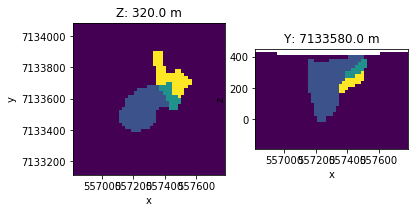

In [4]:
initm[initm==-100] = np.nan

# Create a figure and plot sections
fig, ax1 = plt.figure(), plt.subplot(1,2,1)
mesh.plotSlice(initm, ax = ax1, normal='Z', ind=18, clim = (0,0.02), pcolorOpts={'cmap':'viridis'})
plt.gca().set_aspect('equal')
plt.title('Z: '+str(mesh.vectorCCz[18]) + " m")

ax2 = plt.subplot(1,2,2)
mesh.plotSlice(initm, ax = ax2, normal='Y', ind=16, clim = (0,0.02), pcolorOpts={'cmap':'viridis'})
plt.gca().set_aspect('equal')
plt.title('Y: '+str(mesh.vectorCCy[16])+' m')

plt.show()

Notice that some of the cells in the model are air and show as white. The code
will detected the air cells from the VALUE specified on line 3 of the input
file. These cells are ignored by the code. Alternatively, the user can input a
topography file or an active model specifying the status of each cells
(0:inactive, 1:active-dynamic, -1:active-static).

### Data

Great, now that we have a mesh and a model, we only need to specify a survey
(i.e. where is the data). Once again, an observation file is provided, as
specified on Line 2 of the input file. We can now forward model some magnetic
data above the synthetic kimberlite.

In [5]:
# Get the survey
survey = driver.survey

# Get the active cells (below topography)
actv = driver.activeCells

# Create mapping to come back from the reduce space later
idenMap = Maps.IdentityMap(nP=len(actv))

# Now that we have a model and a survey we can build the linear system ...
# (use the argument forwardOnly=True to avoid storing the dense forward matrix)
prob = PF.Magnetics.MagneticIntegral(mesh, chiMap=idenMap, actInd=actv, rtype = 'tmi')

# Pair the survey and problem (data and model space)
survey.pair(prob)

In [6]:
# Forward operators and data are calculated here (wait for it!)
d = prob.fields(driver.m0)

# Add noise to the data and assign uncertainties
survey.dobs = d + np.random.randn(len(d)) # We add some random Gaussian noise (1 nT)
survey.std = np.ones(len(d))*1. # Assign flat uncertainties (1 nT)

Begin calculation of forward operator: ind
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Done 100% ...forward operator completed!!



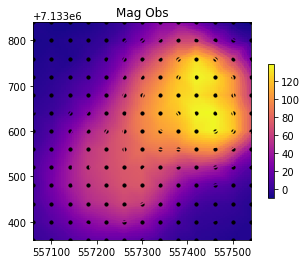

In [7]:
# Then we can plot with the build-in function
PF.Magnetics.plot_obs_2D(survey.srcField.rxList[0].locs,d=survey.dobs ,varstr='Mag Obs')
plt.show()

## Inverse Problem


We have generated synthetic data, we now what to see if we can solve the
inverse problem. Using the usual formulation, we seek a model that can
reproduce the data, let’s say a least-squares measure of the form:

$$
\phi_d =\|\mathbf{W}_d \left( \mathbf{F}\;\mathbf{m} - \mathbf{d}^{obs} \right)\|_2^2\;,
$$

where $\mathbf{W}_d$ are estimated data uncertainties
The inverse problem is hard because we don’t have great data coverage, and the
Earth is big, and there is usually noise in the data. So we need to add
something to regularize it. The simplest way to do it is to penalize solutions
that won’t make sense geologically, for example to assume that the model is
*small* and *smooth*. Most inversion codes use the l2-norm measure such that:

$$
\phi_m = {\| \mathbf{W}_s \;( \mathbf{m - m^{ref}})\|}^2_2  + \sum_{i = x,y,z}  {\|   \mathbf{W}_i  \; \mathbf{G}_i \; \mathbf{m}\|}^2_2
$$

where $m^{ref}$ is any a priori knowledge that we might have about the
solution and $\mathbf{G}_x, \mathbf{G}_y, \mathbf{G}_z$ are finite
difference operators measuring the model spatial gradients along orthogonal
directions. In a purely *unconstrained* case, $m^{ref}$ is usually equal
to some background value (i.e. zero susceptibility).
The full objective function to be minimized can be written as:

$$
\phi (m) =  \phi_d + \beta \phi_m
$$

which will yield our usual function that minimize the data error and model
structure. The trade-off parameter $\beta$ is adjusted in order to get a
*good* balance between data misfit and model

We propose a fancier regularization function that can allow to recover *sparse* and *blocky* solutions.
Starting with the well known Ekblom norm:

$$
\phi_m =  \sum_{i=1}^{nc} {(x_i^2 + \epsilon^2)}^{p/2}
$$

where $x_i$ denotes some function of the model parameter, and $\epsilon$ is a small value to avoid singularity as $m\rightarrow0$.

For p=2, we get the usual least-squares measure and we recover the
regularization presented above. For $p \leq 1$, the function becomes
non-linear which requires some tweaking. We can linearize the function by
updating the penality function iteratively, commonly known as an Iterative Re-
weighted Least-Squares (IRLS) method. The regularization function becomes:

$$
\phi_m^{(k)} =  \frac{1}{2}\sum_{i=1}^{nc} r_i \; x_i^2
$$

where we added the superscript $\square^{(k)}$ to denote the IRLS iterations.
The weights $r(x)$ are computed from model values obtained at a previous
iteration such that:

$$
{r}_i  ={\Big( {({x_i}^{(k-1)})}^{2} + \epsilon^2
\Big)}^{p/2 - 1}
$$

where ${r}(x) \in \mathbb{R}^{nc}$.

In matrix form, our objective function simply becomes:

$$
\phi(m) =   \|\mathbf{W}_d \left( \mathbf{F}\;\mathbf{m} - \mathbf{d}^{obs} \right)\|_2^2 + \beta \Big [ {\| \mathbf{W}_s \;\mathbf{R}_s\;( \mathbf{m - m^{ref}})\|}^2_2  + \sum_{i = x,y,z}  {\|   \mathbf{W}_i\; \mathbf{R}_i  \; \mathbf{G}_i \; \mathbf{m}\|}^2_2  \Big ]
$$

where the IRLS weights $\mathbf{R}_s$ and $\mathbf{R}_i$ are diagonal matrices defined as:

$$
{R}_{s_{jj}}  =  \sqrt{\eta_p}{\Big[ {({m_j}^{(k-1)})}^{2} + \epsilon_p^2 \Big]}^{(p/2 - 1)/2}
$$

$$
{R}_{i_{jj}}  =  \sqrt{\eta_q}{\Big[ {\left ({{(G_i\;m^{(k-1)})}_j }\right)}^{2} + \epsilon_q^2 \Big]}^{(q/2 - 1)/2}
$$

$$
\eta_p =  {\epsilon_p}^{(1-p/2)}\;,
$$
$$
\eta_q =   {\epsilon_q}^{(1-q/2)}
$$

we added two scaling parameters $\eta_p$ and $\eta_q$ for reasons that we won't dicuss here, but turn out to be important to get stable solves.

In order to initialize the IRLS and get an estimate for the stabilizing
parameters $\epsilon_p$ and $\epsilon_q$, we first invert with the
smooth $l_2$-norm. Once the target data misfit has been achieved, the
inversion switches to the sparse regularization. This way we get a good
starting point, hopefully close enough to the true solution. The whole IRLS
process is implemented with a directive added to the inversion workflow.

In [8]:
# It is potential fields, so we will need to push the inverison down
# Create distance weights from our linera forward operator
wr = np.sum(prob.G**2.,axis=0)**0.5
wr = ( wr/np.max(wr) )

In [9]:
# REGULARIZATION
# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of model
# parameters (run last cell to see the histogram before and after IRLS)
reg = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg.cell_weights = wr
reg.norms=driver.lpnorms
reg.eps_p = 3e-4
reg.eps_q = 3e-4

# MISFIT FUNCTION
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1/survey.std

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


In [10]:
# OPTIMIZATION
# We solve the inverse problem with a projected Gauss-Newton solver
opt = Optimization.ProjectedGNCG(maxIter=100 ,lower=0.,upper=1., maxIterLS = 20, maxIterCG= 10, tolCG = 1e-3)

# INVERSE PROBLEM
# Put all the components together
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)

In [ ]:
# DIRECTIVES
# We add a few directives
# First to guess the initial beta
betaest = Directives.BetaEstimate_ByEig()

# Second, we add a pre-conditioner to speedup the CG solves
update_Jacobi = Directives.Update_lin_PreCond()

# This is the directive that will orchestrate the IRLS steps
IRLS = Directives.Update_IRLS(f_min_change = 1e-4, minGNiter=3)

# We add the directives to the inverse problem
inv = Inversion.BaseInversion(invProb, directiveList=[betaest,IRLS,update_Jacobi])

In [ ]:
# SOLVING
# Finally, we run inversion...
m0 = np.ones(len(actv))*1e-4
mrec = inv.run(m0)


# Create active map to return to full space after the inversion 
actvMap = Maps.InjectActiveCells(mesh, actv, -100)

# Map to full space the final model and l2 model
m_lp = actvMap*mrec
m_l2 = actvMap*IRLS.l2model


# Once it is done, we can save the models (l2 and lp) to a file
Mesh.TensorMesh.writeModelUBC(mesh, basePath + os.path.sep +  'SimPEG_MAG_l2l2.sus',m_l2)
Mesh.TensorMesh.writeModelUBC(mesh, basePath + os.path.sep +  'SimPEG_MAG_lplq.sus',m_lp)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.45e+09  2.86e+05  0.00e+00  2.86e+05    1.45e+02      0              
   1  7.25e+08  2.43e+05  1.36e-05  2.53e+05    1.44e+02      0              
   2  3.62e+08  2.12e+05  4.51e-05  2.28e+05    1.43e+02      0   Skip BFGS  
   3  1.81e+08  1.68e+05  1.34e-04  1.92e+05    1.42e+02      0   Skip BFGS  
   4  9.06e+07  1.18e+05  3.35e-04  1.48e+05    1.40e+02      0   Skip BFGS  
   5  4.53e+07  7.26e+04  6.89e-04  1.04e+05    1.37e+02      0   Skip BFGS  
   6  2.26e+07  4.08e+04  1.18e-03  6.76e+04    1.33e+02      0   

Now we can plot sections and compare the smooth and compact models with the
true solution.

In [ ]:
mesh = Mesh.TensorMesh.readUBC(basePath + os.path.sep + "Mesh.msh")

# Load models
m_lp = Mesh.TensorMesh.readModelUBC(mesh, basePath + os.path.sep +  "SimPEG_MAG_lplq.sus")
m_l2 = Mesh.TensorMesh.readModelUBC(mesh, basePath + os.path.sep +  "SimPEG_MAG_l2l2.sus")
m_true = Mesh.TensorMesh.readModelUBC(mesh, basePath + os.path.sep +  "Initm.sus")

m_lp[m_lp==-100] = np.nan
m_l2[m_l2==-100] = np.nan
m_true[m_true==-100] = np.nan

fig = plt.figure()
vmin, vmax = 0.0, 0.015
xmin, xmax = -500 + 557300, 500 + 557300
ymin, ymax = -500 + 7133600, 500 + 7133600
zmin, zmax = -500 + 450, 0 + 450
indz = 17
indx = 17

# Axis label
x = np.linspace(xmin+200, xmax-200,3)
y = np.linspace(zmin+50, zmax-50,3)

ax1 = plt.subplot(1,1,1)
pos =  ax1.get_position()
ax1.set_position([pos.x0-0.1, pos.y0+0.3,  pos.width*0.5, pos.height*0.5])
dat = mesh.plotSlice(m_l2, ax = ax1, normal='Z', ind=indz, clim=np.r_[vmin, vmax],pcolorOpts={'cmap':'viridis'})
#     plt.colorbar(dat[0])
plt.gca().set_aspect('equal')
plt.title('Smooth')
ax1.xaxis.set_visible(False)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.ylabel('Northing (m)')
labels = ax1.get_yticklabels()
plt.setp(labels, rotation=90)

# ax2 = plt.subplot(2,2,3)
pos =  ax1.get_position()
ax2 = fig.add_axes([pos.x0+0.0525, pos.y0 - 0.315,  pos.width*0.725, pos.height])
# ax2.yaxis.set_visible(False)
# ax2.set_position([pos.x0 -0.04 , pos.y0,  pos.width, pos.height])

dat = mesh.plotSlice(m_l2, ax = ax2, normal='Y', ind=indx, clim=np.r_[vmin, vmax],pcolorOpts={'cmap':'viridis'})
#     plt.colorbar(dat[0])
plt.gca().set_aspect('equal')
plt.title('')
plt.xlim(xmin, xmax)
plt.ylim(zmin, zmax)
ax2.set_xticks(x)
ax2.set_xticklabels(map(str, map(int, x)),size=12)
plt.xlabel('Easting (m)')
plt.ylabel('Elev. (m)')
ax2.set_yticks(y)
ax2.set_yticklabels(map(str, map(int, y)),size=12)
labels = ax2.get_yticklabels()
plt.setp(labels, rotation=90)

## Add compact model
ax3 = fig.add_axes([pos.x0+0.3, pos.y0,  pos.width, pos.height])
dat = mesh.plotSlice(m_lp, ax = ax3, normal='Z', ind=indz, clim=np.r_[vmin, vmax],pcolorOpts={'cmap':'viridis'})
#     plt.colorbar(dat[0])
plt.gca().set_aspect('equal')
plt.title('Compact')
ax3.xaxis.set_visible(False)
ax3.yaxis.set_visible(False)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

ax4 = fig.add_axes([pos.x0+0.3525, pos.y0 - 0.315,  pos.width*0.725, pos.height])
# ax2.yaxis.set_visible(False)
# ax2.set_position([pos.x0 -0.04 , pos.y0,  pos.width, pos.height])

dat = mesh.plotSlice(m_lp, ax = ax4, normal='Y', ind=indx, clim=np.r_[vmin, vmax],pcolorOpts={'cmap':'viridis'})
#     plt.colorbar(dat[0])
plt.gca().set_aspect('equal')
ax4.yaxis.set_visible(False)
plt.title('')
plt.xlim(xmin, xmax)
plt.ylim(zmin, zmax)
ax4.set_xticks(x)
ax4.set_xticklabels(map(str, map(int, x)),size=12)
plt.xlabel('')
# ylabel('Elev. (m)')

## Add True model
ax5 = fig.add_axes([pos.x0+0.6, pos.y0,  pos.width, pos.height])
dat = mesh.plotSlice(m_true, ax = ax5, normal='Z', ind=indz, clim=np.r_[vmin, vmax],pcolorOpts={'cmap':'viridis'})
#     plt.colorbar(dat[0])
plt.gca().set_aspect('equal')
plt.title('True')
ax5.xaxis.set_visible(False)
ax5.yaxis.set_visible(False)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

ax6 = fig.add_axes([pos.x0+0.6525, pos.y0 - 0.315,  pos.width*0.725, pos.height])
# ax2.yaxis.set_visible(False)
# ax2.set_position([pos.x0 -0.04 , pos.y0,  pos.width, pos.height])

dat = mesh.plotSlice(m_true, ax = ax6, normal='Y', ind=indx, clim=np.r_[vmin, vmax],pcolorOpts={'cmap':'viridis'})
#     plt.colorbar(dat[0])
plt.gca().set_aspect('equal')
ax6.yaxis.set_visible(False)
plt.title('')
plt.xlim(xmin, xmax)
plt.ylim(zmin, zmax)
ax6.set_xticks(x)
ax6.set_xticklabels(map(str, map(int, x)),size=12)
plt.xlabel('')
# ylabel('Elev. (m)')

pos =  ax4.get_position()
cbarax = fig.add_axes([pos.x0 , pos.y0+0.05 ,  pos.width, pos.height*0.1])  ## the parameters are the specified position you set
cb = fig.colorbar(dat[0],cax=cbarax, orientation="horizontal", ax = ax4, ticks=np.linspace(vmin,vmax, 4),format='%.3f')
cbarax.tick_params(labelsize=12)
# cb.ax.xaxis.set_label_position('top')
cb.set_label("Susceptibility (SI)",size=14)

plt.tight_layout()
plt.show()

In [ ]:
# remove downloaded files
import shutil
shutil.rmtree(basePath)

# [os.remove(basePath + psep +f) for f in cloudfiles]
# os.removedirs(os.path.expanduser(basePath))

### Summary


We have inverted magnetic field data over a synthetic kimberlite pipe, using
both a smooth and compact penalty. The smooth model gives a conservative and robust estimate of
the kimberlite pipe location, as well as providing an excellent starting point
for the sparse regularization. The compact model on the other hand gives a
much closer estimate of susceptibility values and shape of the magnetic
anomaly. More details about the scaled IRLS method can be found in this [thesis](https://open.library.ubc.ca/cIRcle/collections/ubctheses/24/items/1.0166794)